In [1]:
from train import *
from model import *
from helpers import *

import os
import plac
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from IPython.display import clear_output

import numpy as np
from PIL import Image

import torch
from torch import nn, Tensor
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.datasets as dset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    dtype = torch.FloatTensor

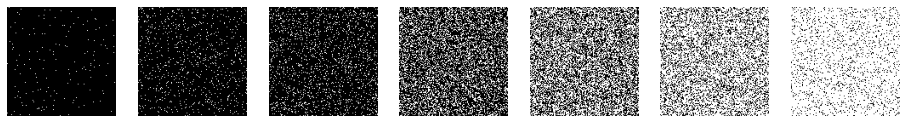

In [2]:
num_of_low_shots = 8
num_of_val = 24
image_size = 128

# given mask
img_mask_pil = Image.open('./mask.png')
mask_np = pil_to_np(img_mask_pil)
mask_var = np_to_var(mask_np).type(dtype) # float within 0~1

# random masks
ratios = np.array([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9])
masks = torch.zeros(len(ratios), 3, image_size, image_size).to(device)

plt.figure(figsize=(16, 8))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    tmp = torch.cuda.FloatTensor(1, 1, image_size, image_size).uniform_() < ratios[i]
    tmp = tmp.view(-1, 1, 128, 128)
    
    mask_np = var_to_np(tmp)
    mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * 3)
    masks[i] = np_to_var(mask_np).type(dtype)

    plt.imshow(mask_np.transpose(1, 2, 0))
    plt.axis('off');

In [3]:
# low shots
# Root directory for dataset
data_root = "./CelebA_data/celeba"

batch_size = 1
data_set = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor() ]))

train_set = torch.utils.data.Subset(data_set, range(0, num_of_low_shots, 1))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# validate images
val_set = torch.utils.data.Subset(data_set, range(27, 51, 1))
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=1)

In [4]:
code_dim = 128
Z = np.random.normal(size=(len(train_set), 1, code_dim)).astype(np.float32) # (number of low shots, 128)
Z = torch.tensor(Z, requires_grad=True).to(device)

LV_Z = latent_var(Z).to(device)
pretrain_decoder = dcgan(code_dim).to(device)

g = CombinedNets(LV_Z, pretrain_decoder).to(device)
g.apply(weight_init)
print(get_n_params(g))
print(g)

13246336
CombinedNets(
  (Z): latent_var()
  (Decoder): dcgan(
    (dcnn): Sequential(
      (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(128, 64,

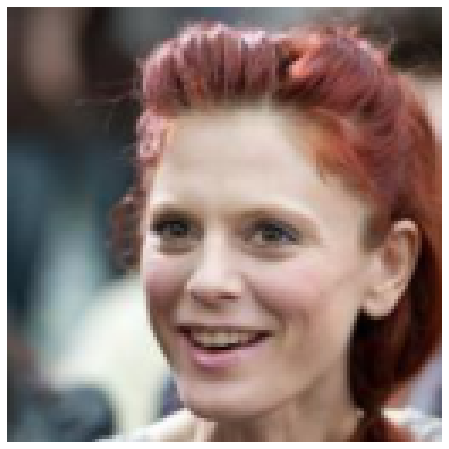

In [5]:
# prepare for pre-train
loss_fn = nn.MSELoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(g.parameters(), lr=learning_rate)

Xi_train, _ = (next(iter(train_loader))) # Xi_val: [3, 3, 128, 128]
train_image_index = np.arange(0, len(train_set))

# low shots in the current training batch
plt.figure(figsize=(16, 8))
for i in range(len(Xi_train)):
    plt.subplot(1, len(Xi_train), i + 1)
    imgshow(Xi_train[i])
    plt.axis('off');

In [6]:
n_epochs = 4000
save_root = "./low_shots_celeb/checkpoint/"

g, Z = pre_train(n_epochs, 
                 train_loader, 
                 g, 
                 Z,
                 optimizer, 
                 pretrain_decoder,
                 save_root,
                 dtype)

pre-train epoch: 10 	 average loss: 0.076092
pre-train epoch: 20 	 average loss: 0.073325
pre-train epoch: 30 	 average loss: 0.070640
pre-train epoch: 40 	 average loss: 0.068666
pre-train epoch: 50 	 average loss: 0.071211
pre-train epoch: 60 	 average loss: 0.069227
pre-train epoch: 70 	 average loss: 0.070826
pre-train epoch: 80 	 average loss: 0.070478
pre-train epoch: 90 	 average loss: 0.069797
pre-train epoch: 100 	 average loss: 0.069757
pre-train epoch: 110 	 average loss: 0.070155
pre-train epoch: 120 	 average loss: 0.069016
pre-train epoch: 130 	 average loss: 0.068490
pre-train epoch: 140 	 average loss: 0.068838
pre-train epoch: 150 	 average loss: 0.069250
pre-train epoch: 160 	 average loss: 0.068818
pre-train epoch: 170 	 average loss: 0.068443
pre-train epoch: 180 	 average loss: 0.069048
pre-train epoch: 190 	 average loss: 0.068557
pre-train epoch: 200 	 average loss: 0.068737
pre-train epoch: 210 	 average loss: 0.069108
pre-train epoch: 220 	 average loss: 0.0684

pre-train epoch: 1780 	 average loss: 0.067782
pre-train epoch: 1790 	 average loss: 0.068227
pre-train epoch: 1800 	 average loss: 0.067716
pre-train epoch: 1810 	 average loss: 0.068125
pre-train epoch: 1820 	 average loss: 0.068094
pre-train epoch: 1830 	 average loss: 0.068010
pre-train epoch: 1840 	 average loss: 0.067869
pre-train epoch: 1850 	 average loss: 0.068243
pre-train epoch: 1860 	 average loss: 0.067969
pre-train epoch: 1870 	 average loss: 0.068149
pre-train epoch: 1880 	 average loss: 0.067799
pre-train epoch: 1890 	 average loss: 0.067754


KeyboardInterrupt: 

In [7]:
# pre-train
epoch_for_pre = 15000
g, Z = pre_train(epoch_for_pre, 
                 train_loader, 
                 g, 
                 Z,
                 train_image_index,
                 optimizer, 
                 pretrain_decoder,
                  "./low_shots_celeb/checkpoint/current_decoder_pre_8_shots.pt")

Pre-train Epoch: 200 	 Average Loss: 0.001832
Pre-train Epoch: 400 	 Average Loss: 0.000876
Pre-train Epoch: 600 	 Average Loss: 0.000571
Pre-train Epoch: 800 	 Average Loss: 0.000484
Pre-train Epoch: 1000 	 Average Loss: 0.000949
Pre-train Epoch: 1200 	 Average Loss: 0.000235
Pre-train Epoch: 1400 	 Average Loss: 0.000198
Pre-train Epoch: 1600 	 Average Loss: 0.000188
Pre-train Epoch: 1800 	 Average Loss: 0.000146
Pre-train Epoch: 2000 	 Average Loss: 0.000156
Pre-train Epoch: 2200 	 Average Loss: 0.000163
Pre-train Epoch: 2400 	 Average Loss: 0.000275
Pre-train Epoch: 2600 	 Average Loss: 0.000114
Pre-train Epoch: 2800 	 Average Loss: 0.000253
Pre-train Epoch: 3000 	 Average Loss: 0.000156
Pre-train Epoch: 3200 	 Average Loss: 0.000122
Pre-train Epoch: 3400 	 Average Loss: 0.000222
Pre-train Epoch: 3600 	 Average Loss: 0.000085
Pre-train Epoch: 3800 	 Average Loss: 0.000138
Pre-train Epoch: 4000 	 Average Loss: 0.000162
Pre-train Epoch: 4200 	 Average Loss: 0.000163
Pre-train Epoch: 

In [8]:
# prepare for training
loss_fn = nn.MSELoss()
code_dim = 128
epoch_for_train_z = 1250
epoch_for_joint_train = 350

# final_output = torch.zeros((len(val_set), 3, 128, 128)).to(device)
# final_z_dict = torch.zeros((len(val_set), 1, code_dim)).to(device)


def train_all_val(mask):
    psnr_list = np.zeros(len(val_set))
    mask = mask.to(device)
    for i, (Xi_val, _, idx_val) in enumerate(val_loader):
        progress = tqdm(total=1, desc='loop % 3d' % i)
        # for image i
        Xi_val = Variable(Xi_val).to(device)
        Xi_val_noisy = (Xi_val * mask).to(device)

        # load pre-trained decoder
        train_decoder = Decoder(code_dim).to(device)
        if os.path.isfile("./low_shots_celeb/checkpoint/current_decoder_pre_8_shots.pt"):
            train_decoder.load_state_dict(torch.load("./low_shots_celeb/checkpoint/current_decoder_pre_8_shots.pt"))
        else:
            train_decoder.apply(weight_init)

        # initial z
        target_z = sample_multivar_normal(Z)

        # combined model train_g
        LV_target_z = LatentVariables(target_z).to(device)
        train_g = CombinedModel(LV_target_z, train_decoder).to(device)

        # train phase: train z to find z_hat
        target_z_hat, _ = train(epoch_for_train_z, 
                                Xi_val_noisy, 
                                train_g, 
                                train_decoder, 
                                target_z, 
                                joint_train=False,
                                learning_rate=5 * 1e-4,
                                save_path="./low_shots_celeb/checkpoint/current_checkpoint_train_z.pt",
                                mask=mask,
                                measure=None)

        # train phase: joint train
        warm_start_z = LatentVariables(target_z_hat).to(device)
        joint_train_g = CombinedModel(warm_start_z, train_decoder).to(device)

        final_z, final_G = train(epoch_for_joint_train, 
                             Xi_val_noisy, 
                             joint_train_g,
                             train_decoder, 
                             target_z_hat, 
                             joint_train=True,
                             learning_rate=1e-4,
                             save_path="./low_shots_celeb/checkpoint/current_checkpoint_final.pt",
                             mask=mask,
                             measure=None)

#         final_output[i] = final_G
#         final_z_dict[i] = final_z
        psnr_list[i] = psnr(Xi_val.cpu().numpy(), final_G.detach().cpu().numpy())

        progress.set_postfix({'loss': loss_fn(final_G * mask, Xi_val* mask).item()})
        progress.update()
        
    return np.mean(psnr_list)

In [9]:
average_pnsr_list = []
for ratio, mask in zip(ratios, masks):
    print("for ratio:", ratio)
    snr = train_all_val(mask)
    average_pnsr_list.append(snr)
    print("psnr = ", snr)
    clear_output(wait=True)

for ratio: 0.9


psnr =  36.801342977810144


[14.307779667386264, 18.43404431843833, 21.427811301422064, 26.58693752783705, 29.41867431265356, 32.40906964759061, 35.90712862381694]


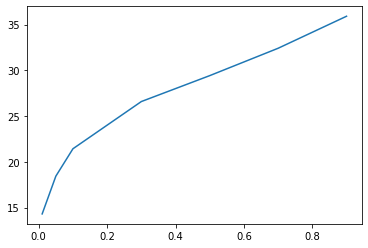

In [9]:
print(average_pnsr_list)
plt.plot(ratios, average_pnsr_list)

[15.038752477777999, 18.499023412712177, 20.798069284295618, 25.70620698127527, 29.656801090618433, 32.858907218503695, 36.801342977810144]


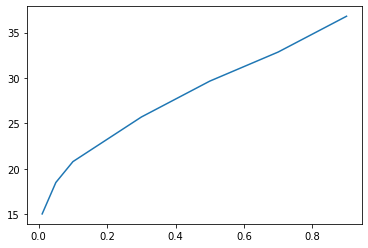

In [10]:
# new
print(average_pnsr_list)
plt.plot(ratios, average_pnsr_list)